# a notebook to compare surface solver issues in more recent Cantera versions

Chain of CSTRs to approximate PFR, based on this example:

https://cantera.org/dev/examples/python/reactors/surf_pfr_chain.html


In [1]:
import cantera as ct
import numpy as np
import scipy.interpolate

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(ct.__version__)

2.6.0


In [3]:
# Pt111
mech_yaml = 'chem_annotated.yaml'

# From the 3.1.0 PFR example
surf = ct.Interface(mech_yaml,'surface1')
gas = surf.adjacent['gas']

print(f'This mechanism contains {gas.n_species} gas species and {surf.n_species} surface species')
print(f'This mechanism contains {gas.n_reactions} gas reactions and {surf.n_reactions} surface reactions')

This mechanism contains 22 gas species and 15 surface species
This mechanism contains 39 gas reactions and 42 surface reactions


### Load an interpolation of temperature profile (from Horn experiment) to impose on reactor

In [4]:
# I copied these from the original file to avoid the pandas/extra file dependency
distances = np.array([-0.004, -0.0038099999999999996, -0.00362, -0.00343, -0.0032400000000000003, -0.0030499999999999998, -0.0028599999999999993,
                      -0.00267, -0.0024800000000000004, -0.00229, -0.0020999999999999994, -0.0019100000000000002, -0.0017199999999999989,
                      -0.0015299999999999995, -0.0013399999999999998, -0.0011500000000000004, -0.0009600000000000009, -0.0007699999999999995,
                      -0.0005800000000000001, -0.0003900000000000006, -0.00019999999999999928, -9.999999999999787e-06, 0.0001799999999999997,
                      0.00036999999999999924, 0.0005600000000000005, 0.00075, 0.0009399999999999995, 0.0011300000000000008, 0.0013200000000000002,
                      0.0015099999999999998, 0.0016999999999999993, 0.0018900000000000006, 0.0020800000000000003, 0.0022699999999999994,
                      0.002460000000000001, 0.0026500000000000004, 0.0028399999999999996, 0.0030299999999999993, 0.0032200000000000006,
                      0.0034100000000000003, 0.0035999999999999995, 0.003789999999999999, 0.00398, 0.00417, 0.004359999999999999, 
                      0.004550000000000001, 0.00474, 0.0049299999999999995, 0.0051199999999999996, 0.0053100000000000005, 0.0055, 0.00569,
                      0.005880000000000001, 0.00607, 0.006259999999999998, 0.006449999999999999, 0.006640000000000001, 0.006829999999999998,
                      0.007019999999999999, 0.007210000000000001, 0.007399999999999999, 0.0075899999999999995, 0.007780000000000001,
                      0.00797, 0.00816, 0.008350000000000002, 0.008539999999999999, 0.00873, 0.00892, 0.00911, 0.009300000000000001,
                      0.009489999999999998, 0.00968, 0.00987, 0.01006, 0.01025, 0.010440000000000001, 0.010630000000000002, 0.01082,
                      0.011010000000000002, 0.0112, 0.01139, 0.011579999999999998, 0.01177, 0.01196, 0.01215, 0.01234, 0.012530000000000001,
                      0.012719999999999999, 0.01291, 0.013100000000000002, 0.01329, 0.01348, 0.013670000000000002, 0.013859999999999999, 
                      0.01405, 0.01424, 0.01443, 0.014620000000000001, 0.014809999999999999, 0.015])
exp_Ts = np.array([402.6021991569596, 407.5140761424839, 414.3582454301749, 420.68095315184536, 429.4635295374276, 439.1697652433412,
                   448.4333644733307, 456.457612871733, 466.1003584286976, 476.99019031063926, 487.5174635138276, 497.904955090448,
                   508.5117016495806, 521.4363932942272, 534.9437441671407, 550.4672298382974, 565.7437309773827, 583.5673486482493,
                   605.0741652870959, 630.4719794204586, 659.6711319718688, 697.6875120770134, 748.361173815275, 807.8280608683114,
                   867.3619875157624, 927.5757721491618, 980.9756374372694, 1030.9867407427228, 1070.823971723205, 1108.4092863382805,
                   1137.1255671464555, 1163.5214072936255, 1182.627329040194, 1198.265008122487, 1211.0483626470432, 1223.3522487768746,
                   1233.7702692719686, 1241.1855761621175, 1245.637492913717, 1249.3926910441835, 1253.0416323807526, 1255.294732078449,
                   1255.302262667718, 1255.2261362220709, 1255.2966098286931, 1254.375094561898, 1251.9975607720894, 1249.9552680854858,
                   1248.48741216898, 1247.484637816645, 1245.9511344093771, 1244.2340264306306, 1241.4968825088067, 1238.525500391319,
                   1235.783013420727, 1232.3746875612933, 1227.8625784401263, 1224.0363187221933, 1222.117164407996, 1220.1600277893383,
                   1215.4287007914231, 1210.3521388510776, 1207.0060526221607, 1205.0128270197008, 1202.3521882384466, 1199.2989377727954,
                   1196.2803979928285, 1193.1670990644675, 1190.654916549449, 1189.505425316352, 1188.8506356054354, 1187.7754869711252,
                   1186.3258793523455, 1184.739858588699, 1182.525524896903, 1179.6996437003745, 1177.8152867729418, 1177.2440919431274,
                   1177.1692926201752, 1175.7659438050096, 1173.419635010658, 1171.6818221302, 1170.2971538176416, 1168.078045649578,
                   1165.9113459672417, 1165.1164606156267, 1165.365999999999, 1165.5758399368578, 1164.7832688239928, 1163.4070213101809,
                   1162.30252596685, 1162.3252113654294, 1162.3719999999992, 1162.3719999999992, 1162.3719999999992, 1162.3719999999992,
                   1162.3719999999992, 1162.3719999999992, 1162.3719999999992, 1162.3719999999992, 1162.3719999999992])

f = scipy.interpolate.interp1d(distances, exp_Ts, fill_value='extrapolate')


In [5]:
# Helper function for getting species index in mechanisms with different naming schemes
def get_i_thing(ref_composition, phase):
    for i in range(phase.n_species):
        if phase.species()[i].composition == ref_composition:
            return i
    assert False
    return -1

In [6]:
# Get indices of key species
i_Ar = get_i_thing({'Ar': 1.0}, gas)
i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
i_O2 = get_i_thing({'O': 2.0}, gas)
i_CO2 = get_i_thing({'C': 1.0, 'O': 2.0}, gas)
i_H2O = get_i_thing({'H': 2.0, 'O': 1.0}, gas)
i_H2 = get_i_thing({'H': 2.0}, gas)
i_CO = get_i_thing({'C': 1.0, 'O': 1.0}, gas)

i_X = get_i_thing({'X': 1.0}, surf)

In [13]:
#######################################################################
# Input Parameters, from Horn 2007
#######################################################################

N_reactors = 1001
T_in = 700
total_pfr_len = 0.1

individual_cstr_len = total_pfr_len / N_reactors
reactor_diameter = 0.0165
cross_section_area = (reactor_diameter / 2.0) ** 2.0 * np.pi
porosity = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
cat_area_per_vol = 16000  # Emily said this was made up, but I feel like I've seen it somewhere else. TBD find true provenance
flow_rate = 4.7  # slpm
flow_rate = flow_rate * 0.001 / 60  # m^3/s
tot_flow = 0.208  # from Horn 2007, constant inlet flow rate in mol/min, equivalent to 4.7 slpm
velocity = flow_rate / cross_section_area  # m/s
residence_time = individual_cstr_len / velocity # unit in s

# The PFR will be simulated by a chain of 'NReactors' stirred reactors
# but we'll assume there's catalyst throughout the whole reactor
individual_cstr_vol = cross_section_area * individual_cstr_len * porosity

# catalyst area in one reactor
individual_cstr_cat_area = cat_area_per_vol * individual_cstr_vol

use_temperature_profile = True

In [14]:
T = T_in

surf = ct.Interface(mech_yaml,'surface1')
gas = surf.adjacent['gas']

x_CH4 = 0.296
x_O2 = 0.147
x_Ar = 1.0 - x_CH4 - x_O2

X = f'{gas.species_names[i_CH4]}: {x_CH4}, {gas.species_names[i_O2]}: {x_O2}, {gas.species_names[i_Ar]}: {x_Ar}'
gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
mass_flow_rate = flow_rate * gas.density_mass
gas.TPX = T, ct.one_atm, X
surf.TP = T, ct.one_atm
initial_coverages = np.zeros_like(surf.coverages)
initial_coverages[i_X] = 1.0
surf.coverages = initial_coverages


# create a new reactor
energy_setting = 'on'
if use_temperature_profile:
    energy_setting = 'off'
r = ct.IdealGasReactor(gas, energy=energy_setting)
r.volume = individual_cstr_vol
upstream = ct.Reservoir(gas, name='upstream')
downstream = ct.Reservoir(gas, name='downstream')
rsurf = ct.ReactorSurface(surf, r, A=individual_cstr_cat_area)
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
if ct.__version__ == '2.6.0':
    v = ct.PressureController(r, downstream, master=m, K=1e-5)
else:
    v = ct.PressureController(r, downstream, primary=m, K=1e-5)

sim = ct.ReactorNet([r])


gas_out = []
surf_out = []
dist_array = np.linspace(0, total_pfr_len, N_reactors)
temperature_profile = f(dist_array)
T_array = []

# Simulate chain of CSTRs
for n in range(N_reactors):
    # Set the state of the reservoir to match that of the previous reactor
    if use_temperature_profile:
        gas.TDY = temperature_profile[n], r.thermo.DP[0], r.thermo.Y
        # surf.TD = temperature_profile[n], surf.TD[1] # this doesn't appear to do anything
        r.syncState()  # impose the temperature profile on the reactor object
        upstream.syncState()
    else:
        gas.TDY = r.thermo.TDY
        # surf.TD = r.thermo.T, surf.TD[1]  # this doesn't appear to do anything
        upstream.syncState()
    sim.reinitialize()  # doesn't seem to make a difference
    sim.advance(sim.time + 1e4 * residence_time)


    T_array.append(surf.T)
    kmole_flow_rate = mass_flow_rate / gas.mean_molecular_weight  # kmol/s
    gas_out.append(1000 * 60 * kmole_flow_rate * gas.X.copy())  # molar flow rate in moles/minute
    surf_out.append(surf.X.copy())


gas_out = np.array(gas_out)
surf_out = np.array(surf_out)
T_array = np.array(T_array)


Text(0.5, 1.0, '2.6.0         1001 reactors')

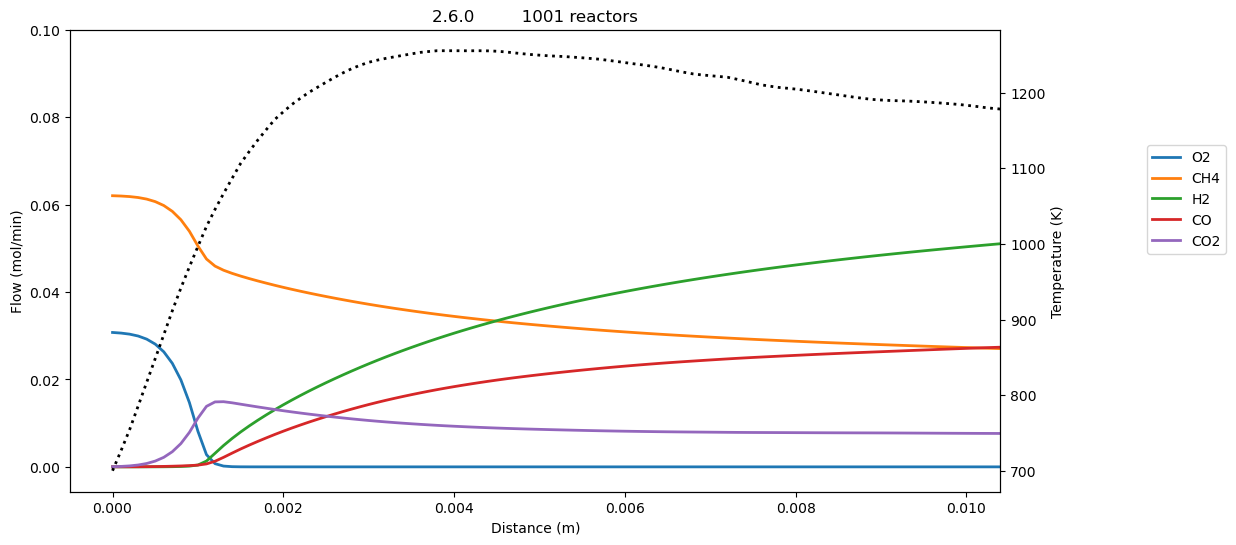

In [15]:
# Plot the result
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linewidth1 = 2.0
linewidth2 = 2.0

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

plt.plot(dist_array, gas_out[:, i_O2], label='O2', color=colors[0], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CH4], label='CH4', color=colors[1], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_H2], label='H2', color=colors[2], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CO], label='CO', color=colors[3], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CO2], label='CO2', color=colors[4], linewidth=linewidth2)

ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dist_array, T_array, label='Temperature', color='k', linestyle=':', linewidth=linewidth2)
ax2.set_ylabel('Temperature (K)')

ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Flow (mol/min)')
ax1.legend(bbox_to_anchor=(1.15, 0.5))
ax1.set_ylim((-0.005686988947011412, 0.1))
ax1.set_xlim((-0.0004950495049504951, 0.010396039603960397))

plt.title(ct.__version__ + f'         {N_reactors} reactors')